# PROBLEM STATEMENT

The objective is to develop a predictive model that estimates the insurance premium a customer should pay based on their personal characteristics and risk-related factors. The model should account for diverse risk profiles and accurately determine appropriate premium amounts tailored to each customer's unique situation.

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
stats.chisqrob = lambda chisq, df:stats.chi2.sf(chisq, df)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import shap
import lime
shap.initjs()
sns.set()

# DATA LOADING

In [203]:
data= pd.read_excel('Data1.xlsx')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,Gauteng,16884.92
1,18,male,33.770,1,no,Western Cape,1725.55
2,28,male,33.000,3,no,Western Cape,4449.46
3,33,male,22.705,0,no,KZN,21984.47
4,32,male,28.880,0,no,KZN,3866.86


# DATA PREPARATION
- cleaning
- handing outliers

In [204]:
data.shape

(1338, 7)

In [205]:
data.duplicated(). sum()

1

In [206]:
data.drop_duplicates(inplace=True)

In [207]:
data.duplicated().sum()

0

In [208]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [209]:
data.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [210]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [211]:
# Check for negative ages 
print(data[data['age'] < 0])
print(data[data['charges'] < 0])
print(data[data['bmi'] < 0])





Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []
Empty DataFrame
Columns: [age, sex, bmi, children, smoker, region, charges]
Index: []


In [212]:
print(data.value_counts())


age  sex     bmi     children  smoker  region        charges 
18   female  20.790  0         no      Western Cape  1607.51     1
48   female  27.360  1         no      North-West    9447.38     1
             25.850  3         yes     Western Cape  24180.93    1
             22.800  0         no      Gauteng       8269.04     1
47   male    47.520  1         no      Western Cape  8083.92     1
                                                                ..
31   female  25.740  0         no      Western Cape  3756.62     1
             23.600  2         no      Gauteng       4931.65     1
             21.755  0         no      KZN           4134.08     1
30   male    44.220  2         no      Western Cape  4266.17     1
64   male    40.480  0         no      Western Cape  13831.12    1
Name: count, Length: 1337, dtype: int64


In [213]:
data.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121638
std,14.044333,6.100468,1.205571,12110.359657
min,18.000000,15.960000,0.000000,1121.870000
25%,27.000000,26.290000,0.000000,4746.340000
50%,39.000000,30.400000,1.000000,9386.160000
75%,51.000000,34.700000,2.000000,16657.720000
max,64.000000,53.130000,5.000000,63770.430000


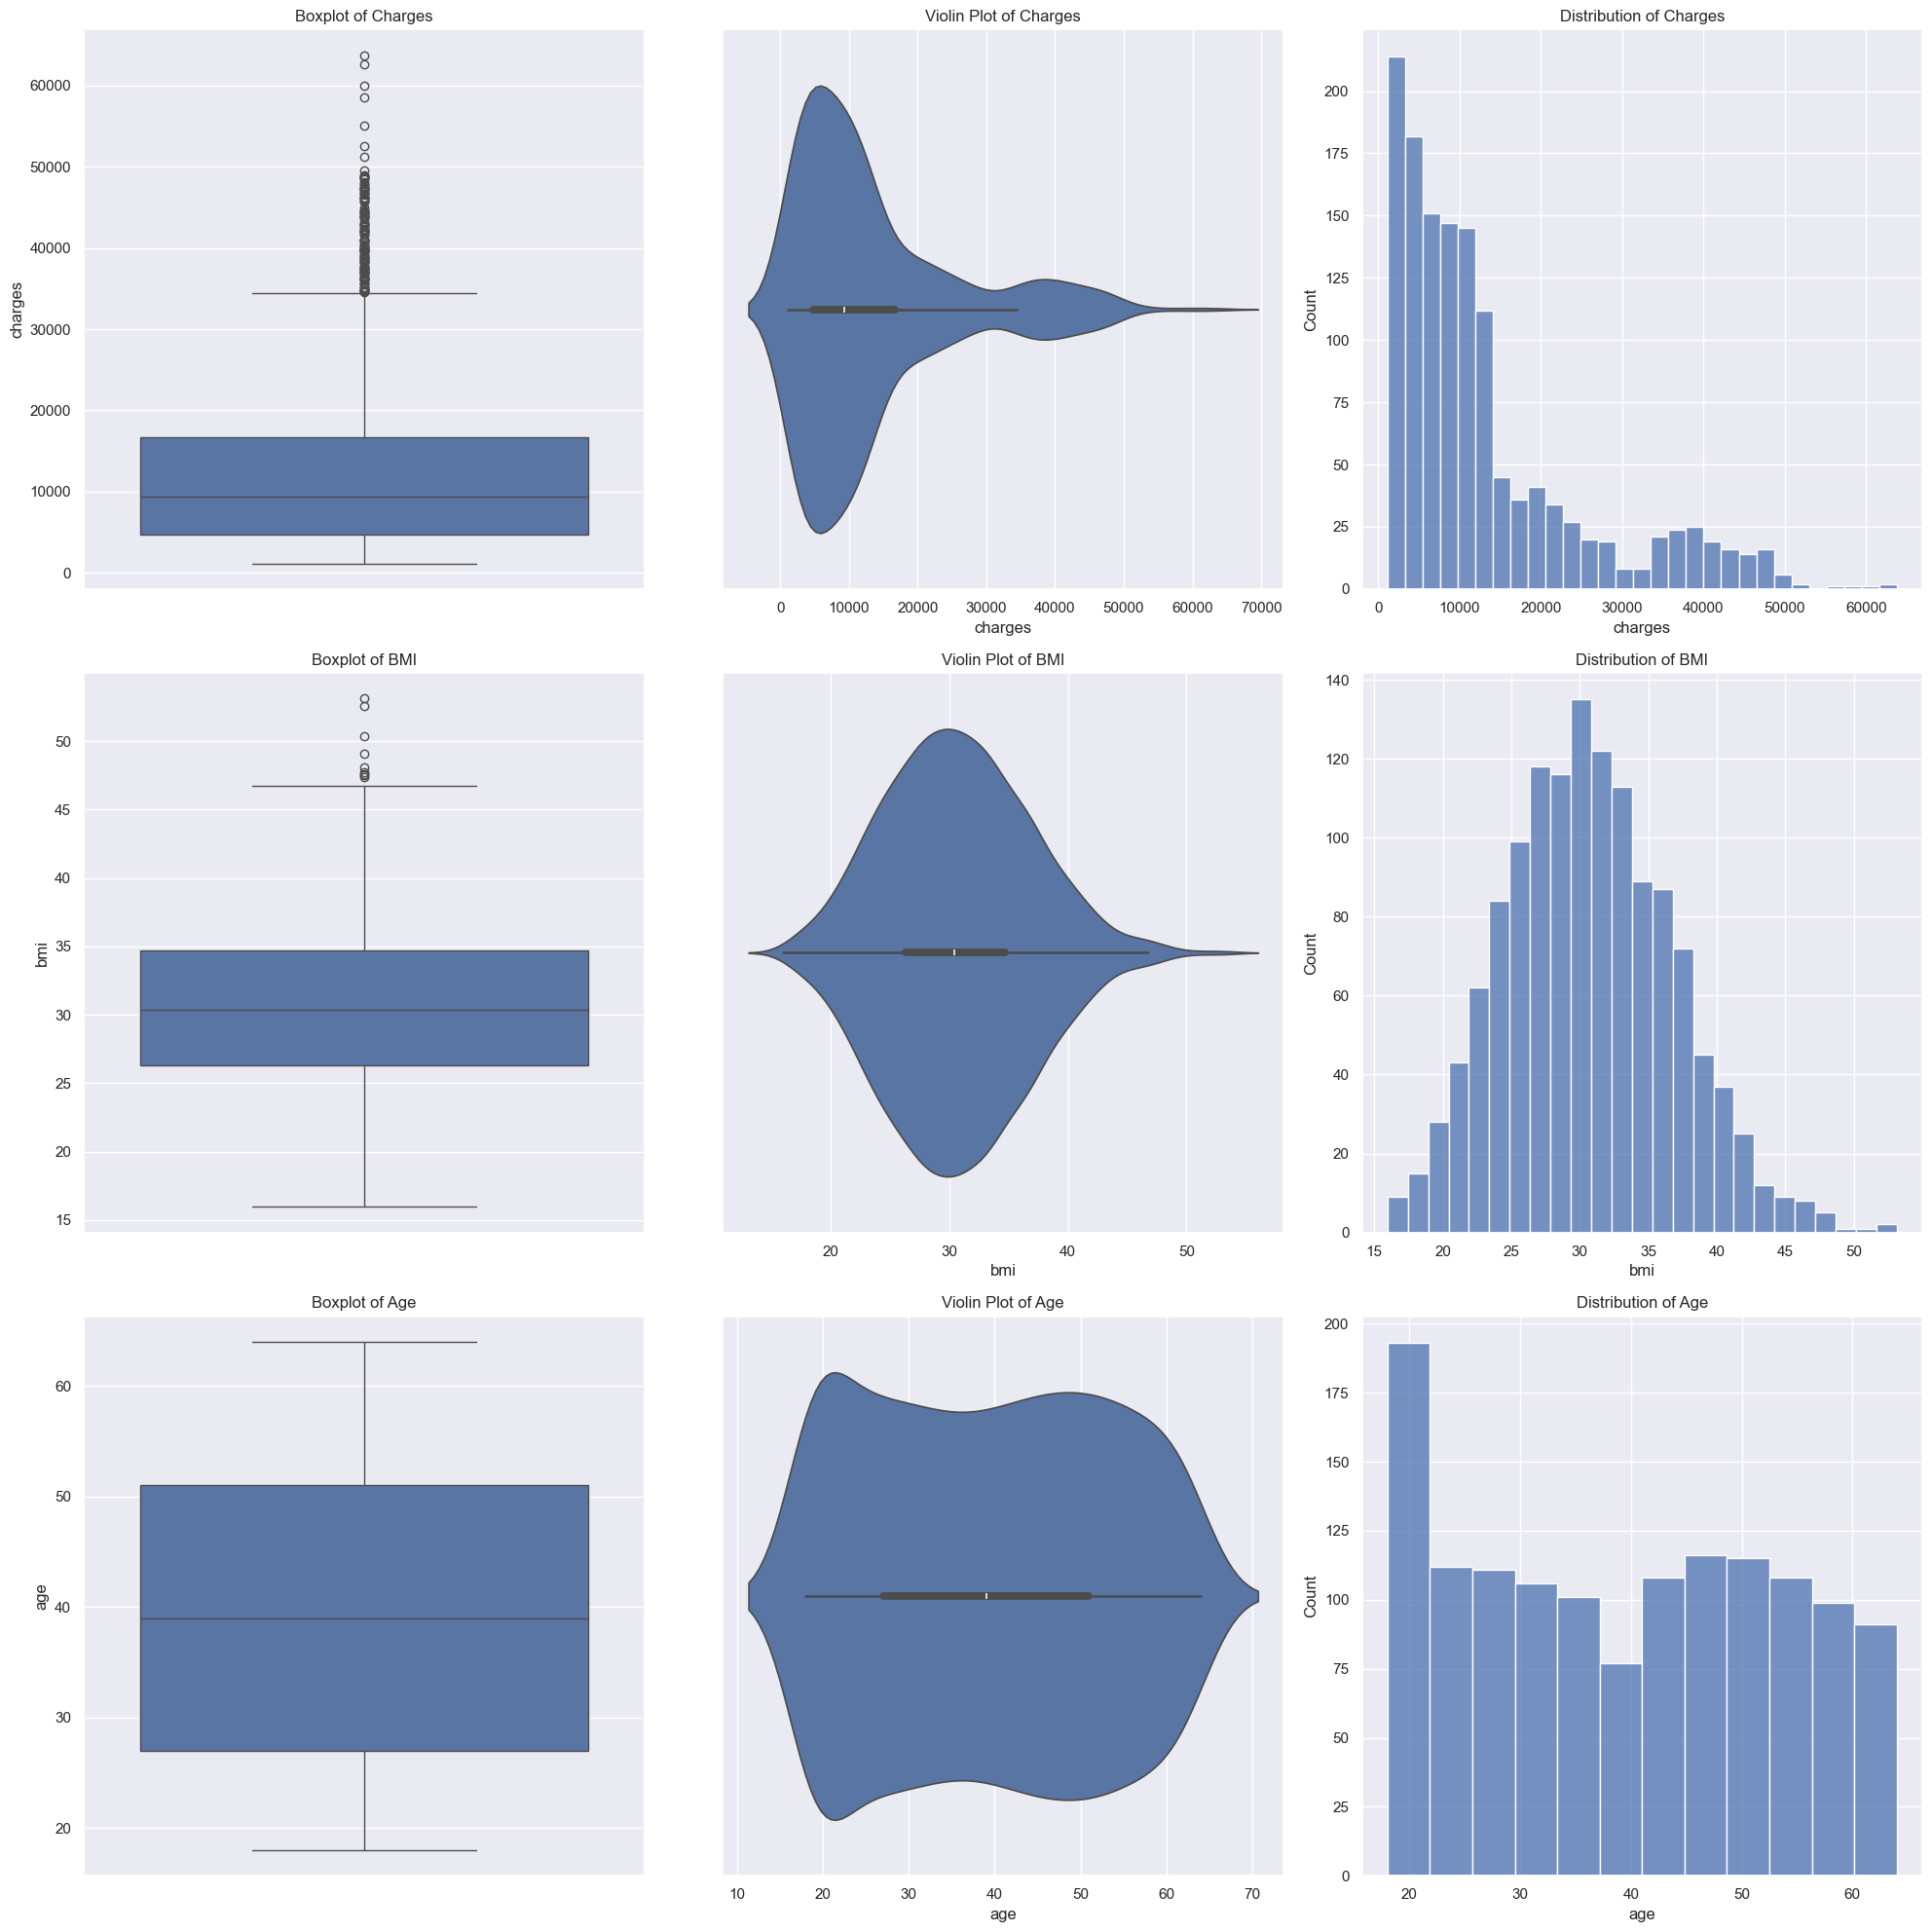

In [214]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# Charges plots
sns.boxplot(data['charges'], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of Charges')

sns.violinplot(data=data, x='charges', ax=axes[0, 1])
axes[0, 1].set_title('Violin Plot of Charges')

sns.histplot(data['charges'], ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Charges')

# BMI plots
sns.boxplot(data['bmi'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of BMI')

sns.violinplot(data=data, x='bmi', ax=axes[1, 1])
axes[1, 1].set_title('Violin Plot of BMI')

sns.histplot(data['bmi'], ax=axes[1, 2])
axes[1, 2].set_title('Distribution of BMI')

# Age plots
sns.boxplot(data['age'], ax=axes[2, 0])
axes[2, 0].set_title('Boxplot of Age')

sns.violinplot(data=data, x='age', ax=axes[2, 1])
axes[2, 1].set_title('Violin Plot of Age')

sns.histplot(data['age'], ax=axes[2, 2])
axes[2, 2].set_title('Distribution of Age')

plt.tight_layout()
plt.show()


### Handling outliers

In [215]:
# for charges
upper_limit = data['charges'].mean()+ 3*data['charges'].std()
lower_limit = data['charges'].mean()- 3*data['charges'].std() 

print(upper_limit," " ,lower_limit)

49610.200609060106   -23051.95733306908


In [216]:
# applying capping
data['charges'] = np.where(data['charges'] < lower_limit, lower_limit, data['charges'])
data['charges'] = np.where(data['charges'] > upper_limit, upper_limit, data['charges'])

In [217]:
# for bmi
upper_limit = data['bmi'].mean()+ 3*data['bmi'].std()
lower_limit = data['bmi'].mean()- 3*data['bmi'].std() 

print(upper_limit," " ,lower_limit)

48.96485698651382   12.362046528819015


In [218]:
# applying capping
data['bmi'] = np.where(data['bmi'] < lower_limit, lower_limit, data['bmi'])
data['bmi'] = np.where(data['bmi'] > upper_limit, upper_limit, data['bmi'])


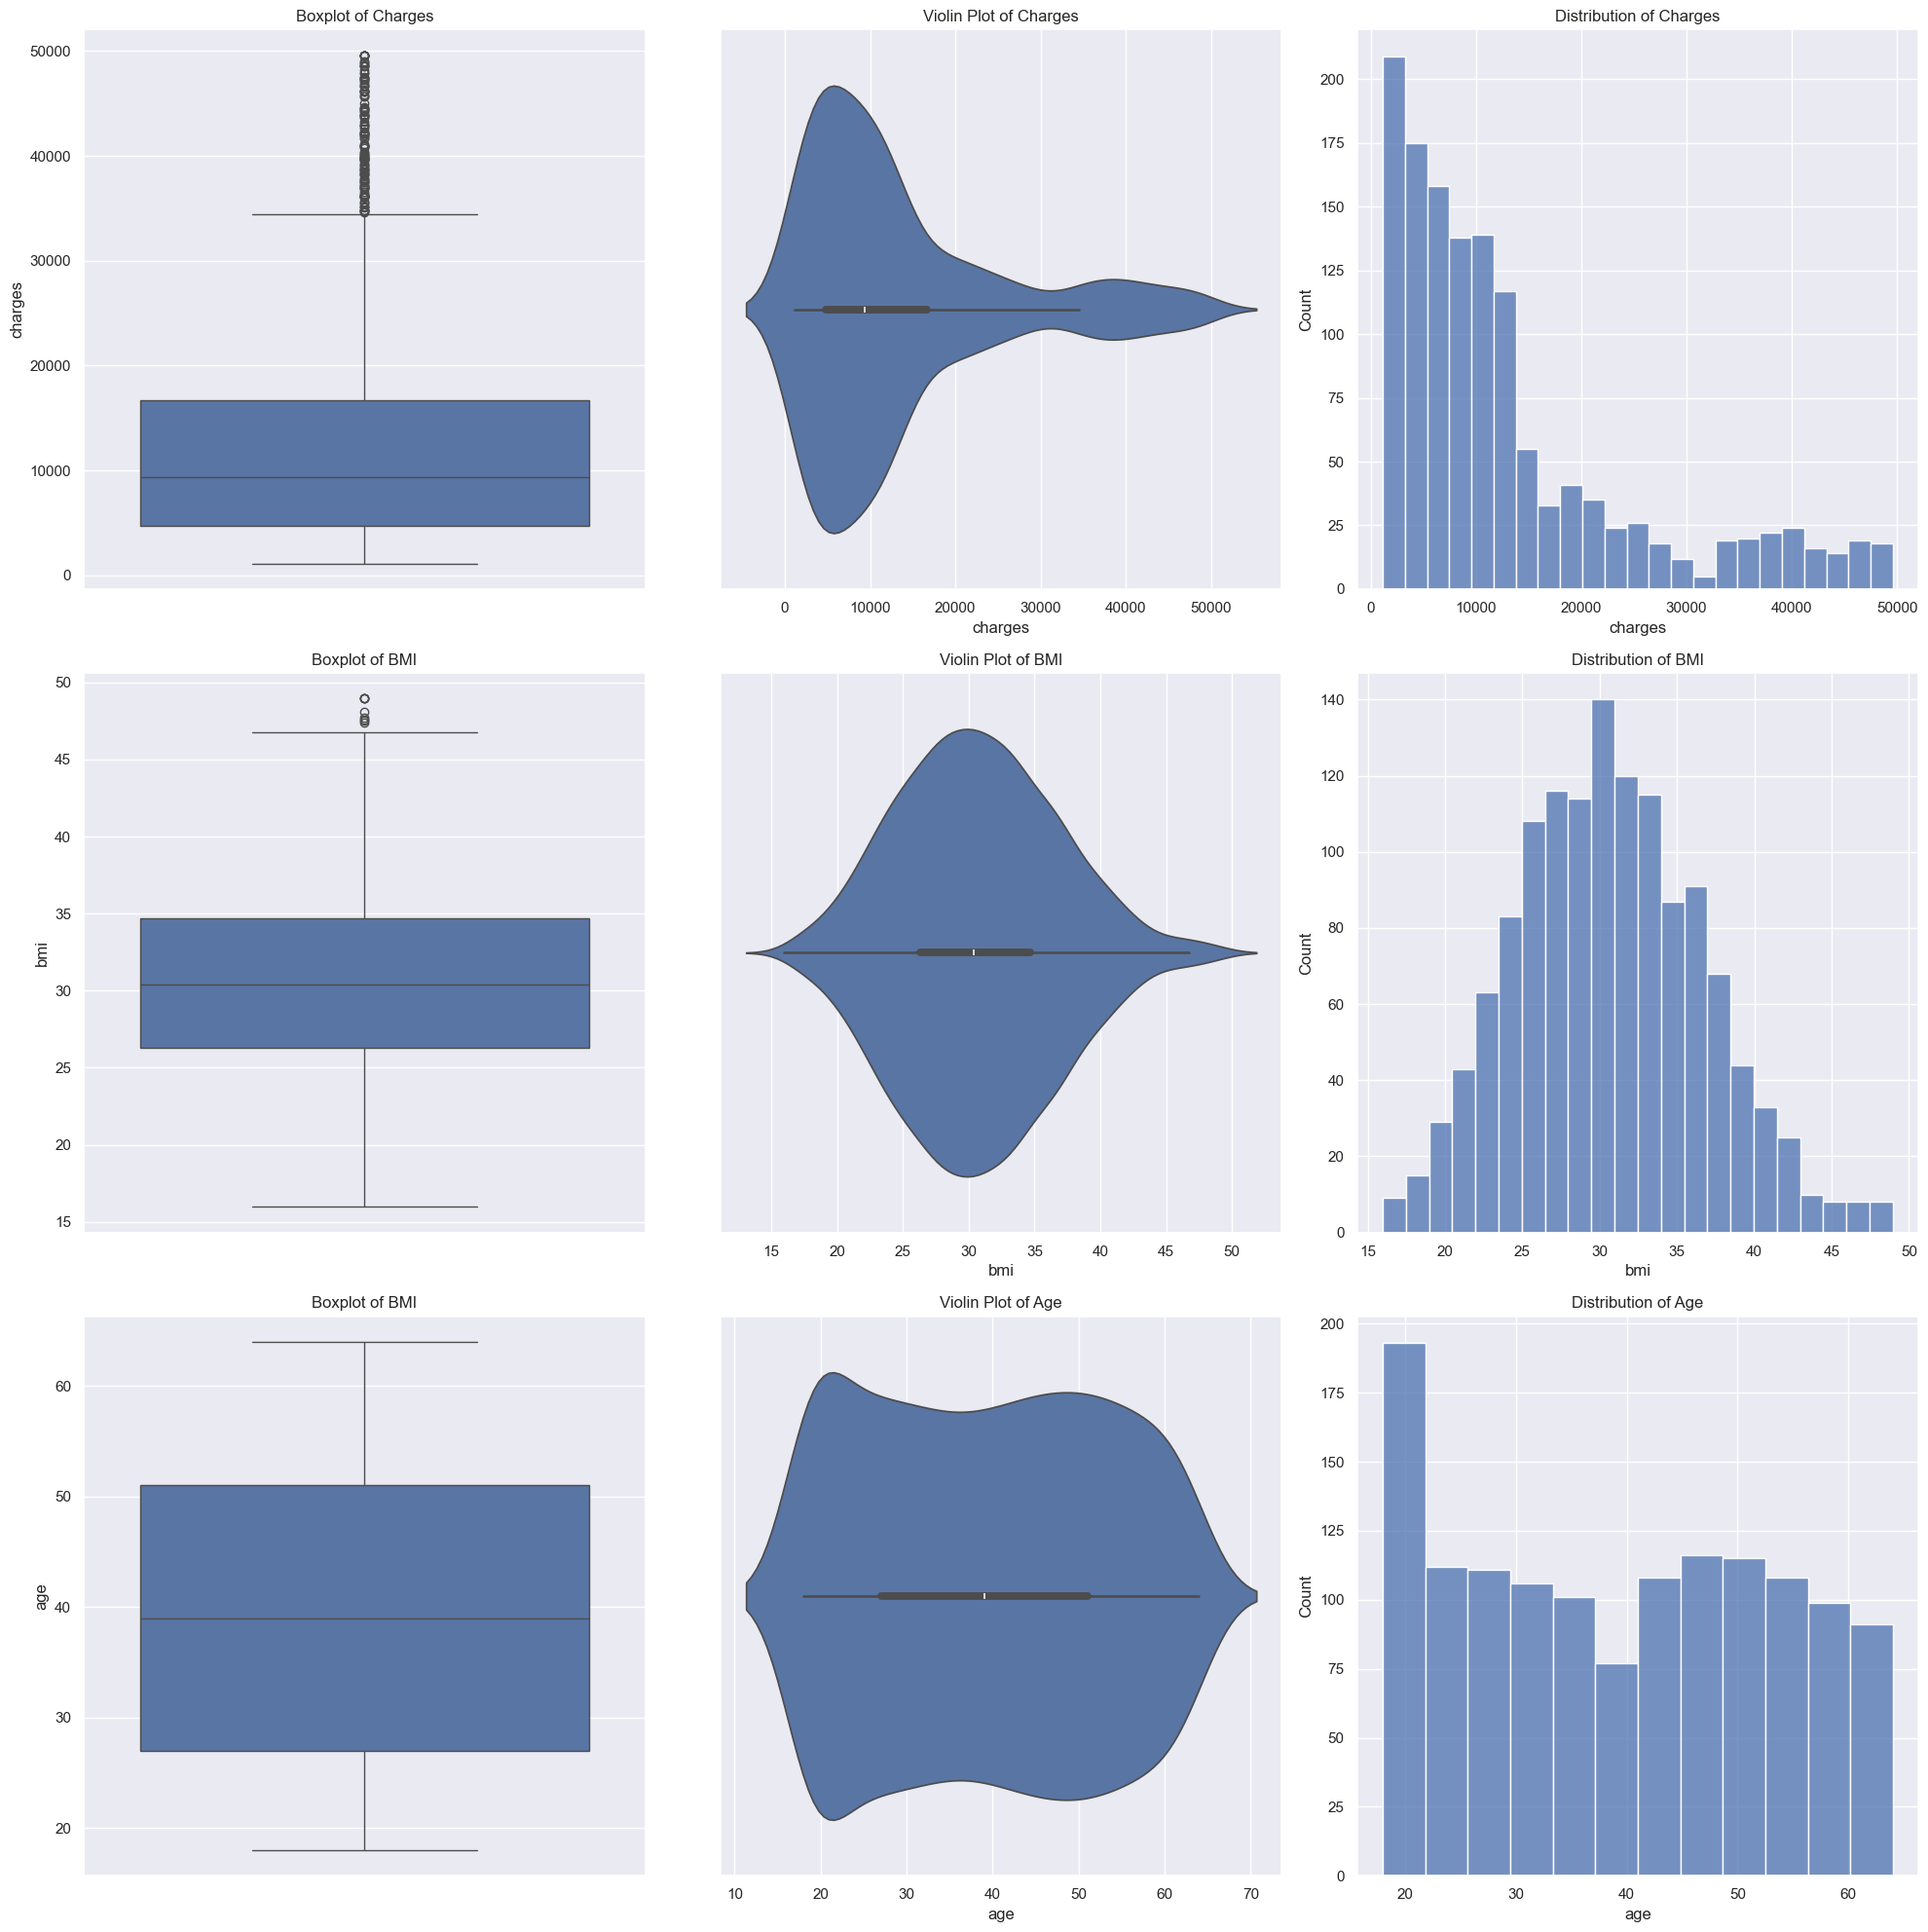

(None,)

In [219]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# charges
sns.boxplot(data['charges'], ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of Charges')

sns.violinplot(data=data, x='charges', ax=axes[0, 1])
axes[0, 1].set_title('Violin Plot of Charges')

sns.histplot(data['charges'], ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Charges')


# bmi plots
sns.boxplot(data['bmi'], ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of BMI')

sns.violinplot(data=data, x='bmi', ax=axes[1, 1])
axes[1, 1].set_title('Violin Plot of BMI')

sns.histplot(data['bmi'], ax=axes[1, 2])
axes[1, 2].set_title('Distribution of BMI')



# age
sns.boxplot(data['age'], ax=axes[2, 0])
axes[2, 0].set_title('Boxplot of BMI')

sns.violinplot(data=data, x='age', ax=axes[2, 1])
axes[2, 1].set_title('Violin Plot of Age')

sns.histplot(data['age'], ax=axes[2, 2])
axes[2, 2].set_title('Distribution of Age')


plt.tight_layout()
plt.show(),  

In [220]:
""" ""
Define the lower and upper percentiles
lower_percentile = data['bmi'].quantile(0.01)
upper_percentile = data['bmi'].quantile(0.99)

# Filter out outliers
data['bmi']= data[(data['bmi'] > lower_percentile) | (data['bmi'] < upper_percentile)]

# Display outliers
print(data['bmi'])

"""""

' ""\nDefine the lower and upper percentiles\nlower_percentile = data[\'bmi\'].quantile(0.01)\nupper_percentile = data[\'bmi\'].quantile(0.99)\n\n# Filter out outliers\ndata[\'bmi\']= data[(data[\'bmi\'] > lower_percentile) | (data[\'bmi\'] < upper_percentile)]\n\n# Display outliers\nprint(data[\'bmi\'])\n\n'

In [221]:
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

<Axes: xlabel='age', ylabel='Count'>

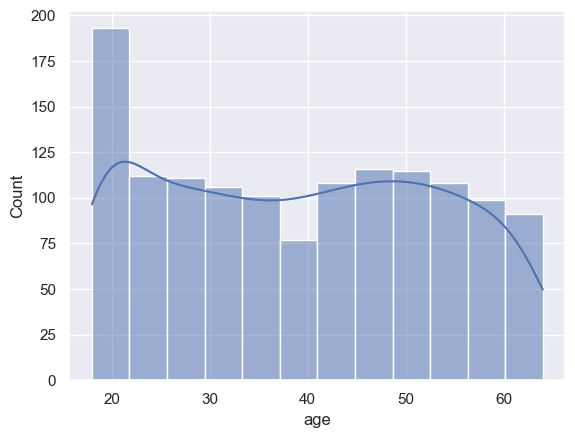

In [222]:
sns.histplot(data=data, x='age', kde=True)


<Axes: xlabel='sex', ylabel='count'>

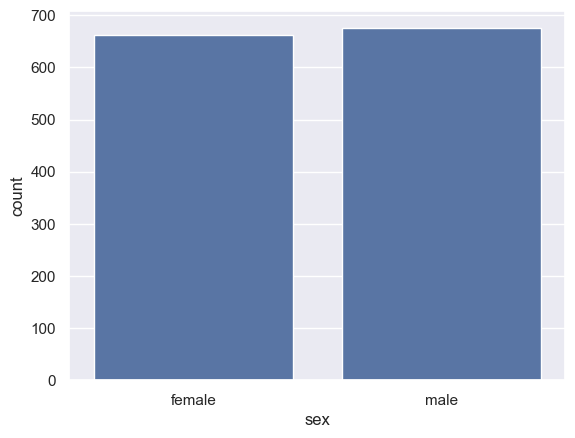

In [223]:
sns.countplot(data=data, x='sex')


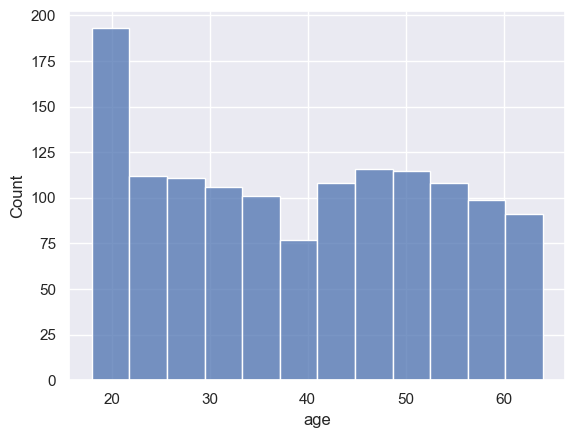

In [224]:
# Histogram for age with hue for sex
sns.histplot(data=data, x='age')
plt.show()



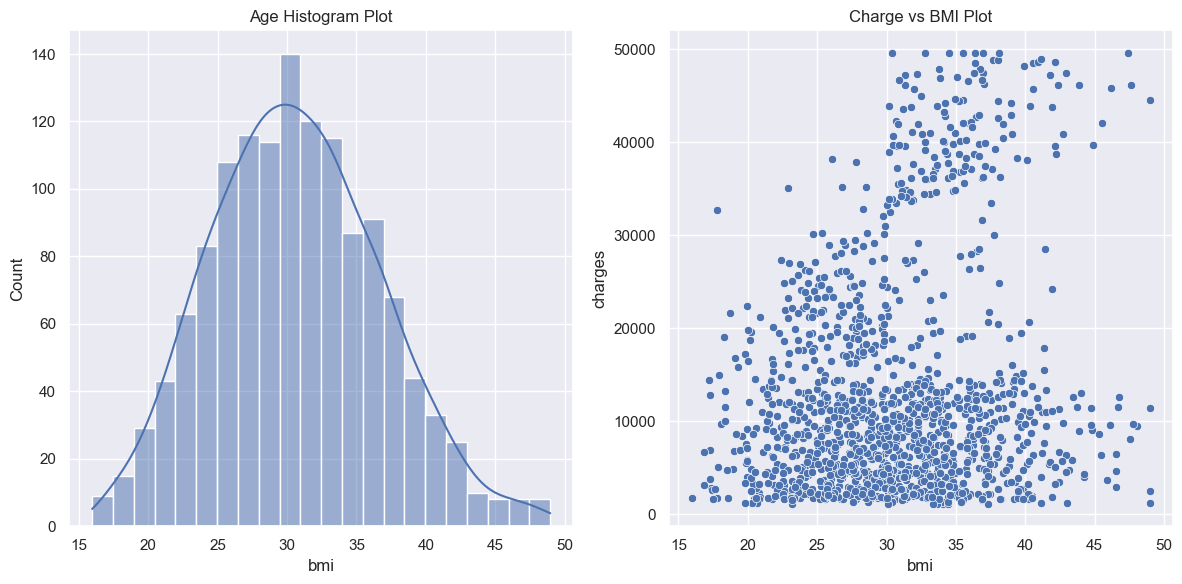

In [225]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

# Histogram for age with hue for sex
sns.histplot(data=data, x='bmi',  kde=True, ax=axes[0])
axes[0].set_title('Age Histogram Plot')

# Scatter plot for age vs charges
sns.scatterplot(data=data, x='bmi', y='charges', ax=axes[1])
axes[1].set_title('Charge vs BMI Plot')

plt.tight_layout()
plt.show()


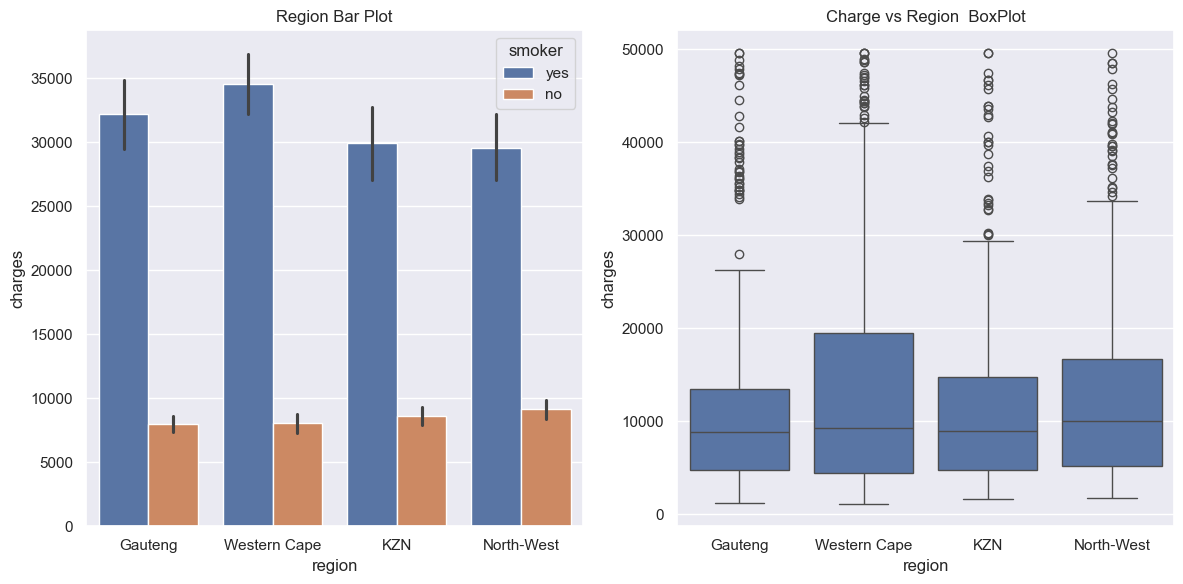

In [226]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

# Histogram for age with hue for sex
sns.barplot(data=data, x='region', y='charges',  hue='smoker',ax=axes[0])
axes[0].set_title('Region Bar Plot')

# Scatter plot for age vs charges
sns.boxplot(data=data, x='region', y='charges', ax=axes[1])
axes[1].set_title('Charge vs Region  BoxPlot')

plt.tight_layout()
plt.show()


In [227]:
pivot_data = data.pivot_table(index='region', columns='smoker', values='charges', aggfunc='mean')


In [228]:
print(pivot_data)


smoker                 no           yes
region                                 
Gauteng       8019.285019  32190.357435
KZN           8582.466955  29917.237262
North-West    9165.531946  29539.791949
Western Cape  8032.216300  34546.723640


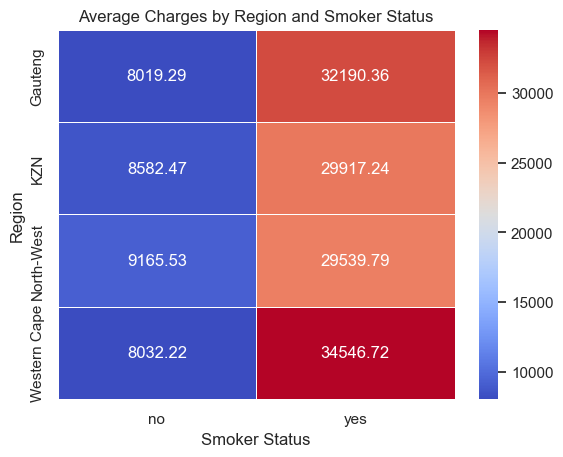

In [229]:
sns.heatmap(pivot_data, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Average Charges by Region and Smoker Status")
plt.ylabel("Region")
plt.xlabel("Smoker Status")
plt.show()


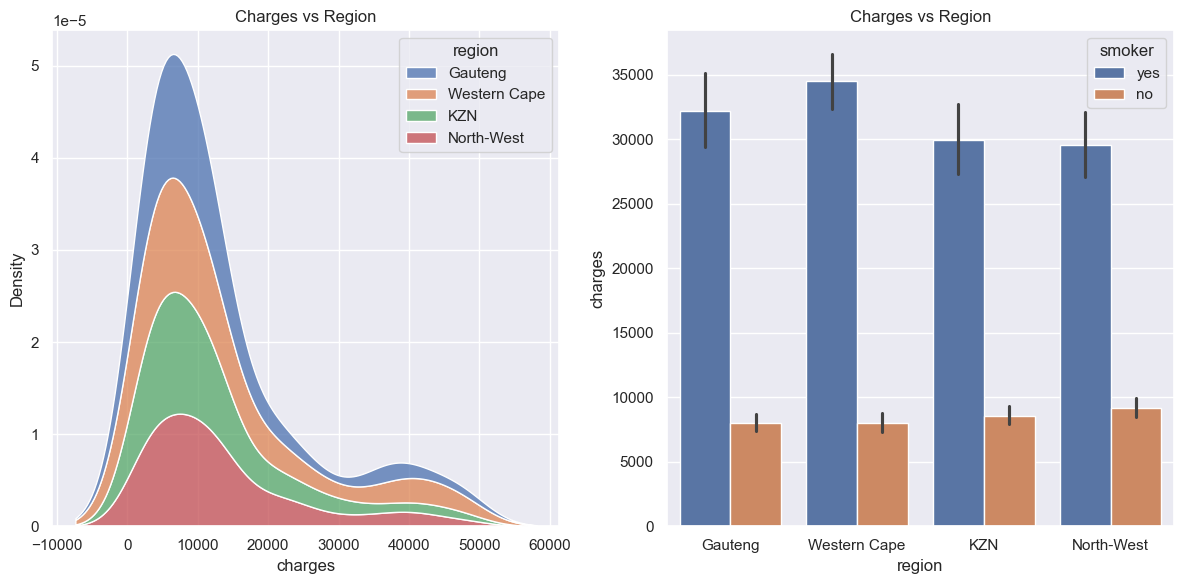

In [230]:
fig, axes = plt.subplots(1,2, figsize=(12,6))

sns.kdeplot(data=data, x="charges", hue="region", multiple="stack", ax=axes[0])
axes[0].set_title('Charges vs Region')

sns.barplot(data=data, x='region', y='charges', hue='smoker', ax=axes[1])
axes[1].set_title('Charges vs Region')


plt.tight_layout()
plt.show()

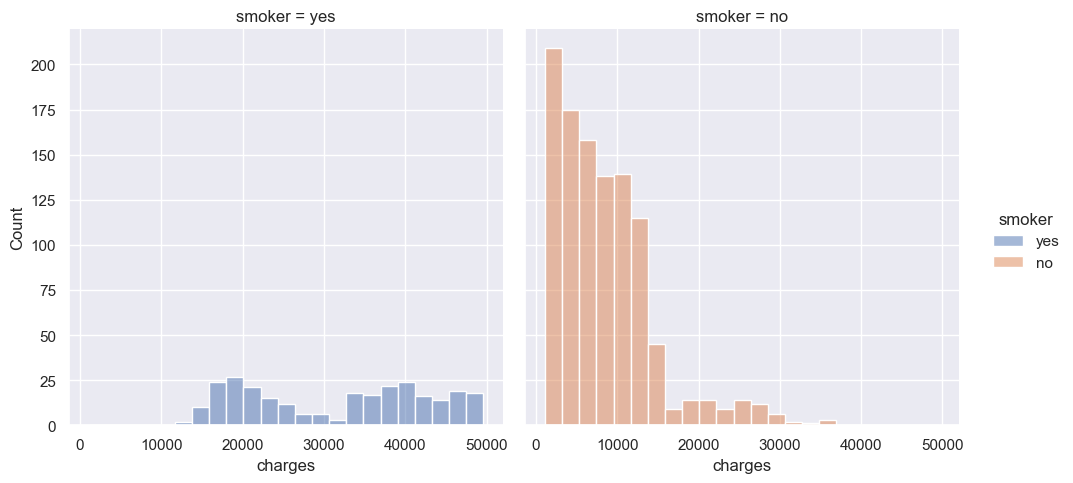

In [231]:
sns.displot(data=data, x="charges", hue="smoker", col="smoker",)

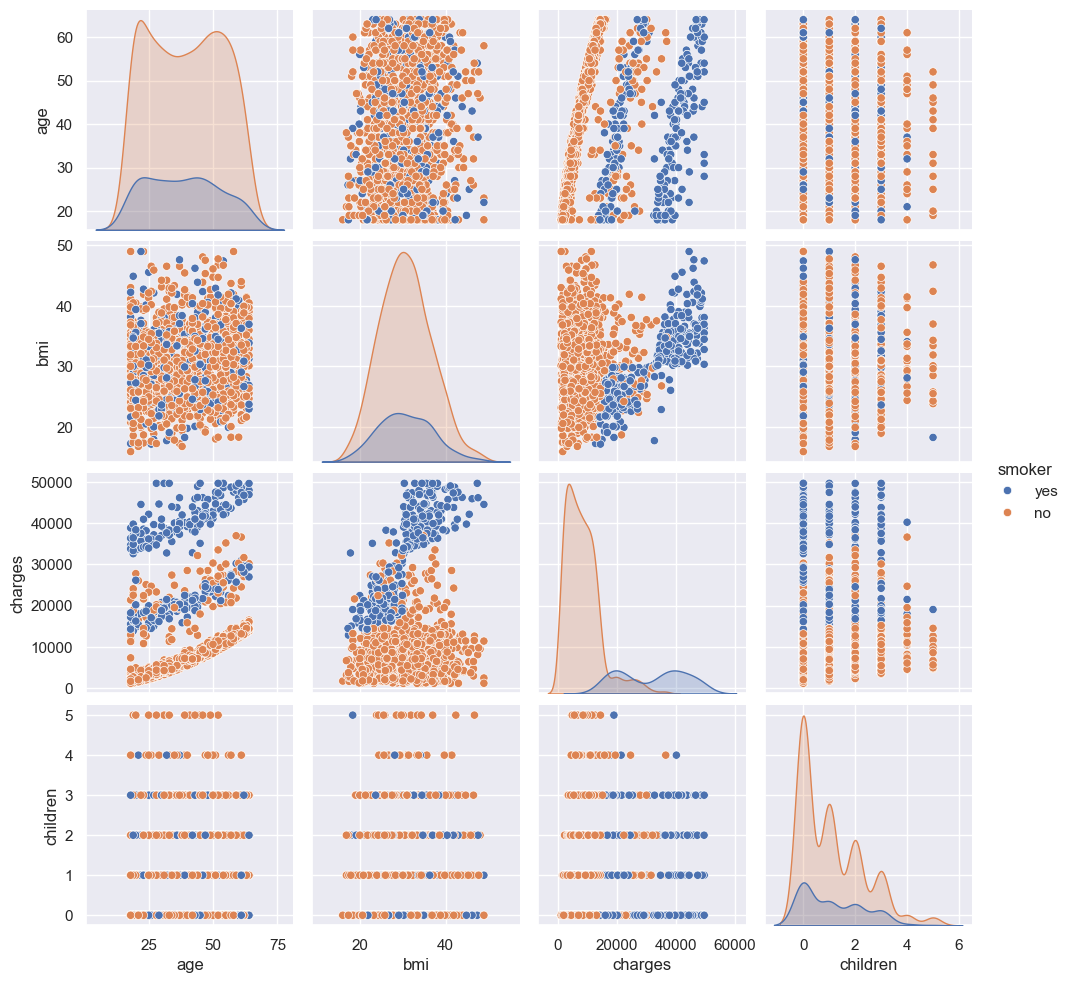

In [232]:
sns.pairplot(data=data, vars=['age', 'bmi', 'charges','children'], hue='smoker')


### EDA SUMNARY ALAYSIS
**Insights**

Exploratory Data Analysis (EDA) provides valuable insights into the dataset before fitting it to a predictive model. Key observations include:

1. **Age Distribution**: The dataset primarily consists of individuals around 20 years old, suggesting younger individuals may influence premium charges due to higher perceived risk.
2. **Premium Charges**: The distribution of premium charges is skewed, with most individuals having lower premiums, but some facing significantly higher charges. Factors like **BMI**, **age**, and **smoking** contribute to higher premiums.
3. **Impact of BMI, Age, and Smoking**: Higher **BMI**, older **age**, and **smoking** are positively correlated with higher premium charges due to associated health risks.
4. **Geographic Analysis**: The **Western Cape** has the highest premium charges, likely due to regional factors such as population density and healthcare access.


In [233]:
data.to_csv('output.csv', index=False)
